# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [139]:
import artm

In [140]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [141]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [164]:
import os
os.environ["ARTM_SHARED_LIBRARY"] = "/Users/adrianoff/dev/BigARTM/build/lib/libartm.dylib"
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", 
                                       target_folder="lectures_batches", 
                                       batch_size=32, gather_dictionary=True)
# Ваш код


##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [166]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, cache_theta=True, topic_names=topic_names, class_ids={"text":1,"author":1})

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [167]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [168]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [169]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(
                                                            name='SparsePhi1', 
                                                            tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=["text"],
                                                            topic_names=["bcg"]
                                                           )
                           )

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [170]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [171]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(
                                                            name='SparsePhi2', 
                                                            tau=-1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=["text"],
                                                            topic_names=["sbj"+str(i) for i in range(T-1)]
                                                           )
                           )

Выполните еще 15 проходов по коллекции.

In [172]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [173]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  церковь русь средневековый император святой власть сага князь папа византийский поэзия церковный рим вера король
sbj1:  планета земля атмосфера вода солнце солнечный белый карлик газ вокруг образовываться поверхность спутник радиус метр
sbj2:  система трудность относительность тест задание преподавание отсчет системный научение компетенция адаптивный обществознание подготовка моделирование спиновый
sbj3:  культура наука рассказывать понятие кандидат исторический каков доктор культурный сознание восприятие филологический феномен владимир личность
sbj4:  право правовой римский юрист искусство суд юридический должник собственность обязательство договор владение собственник исполнение имущество
sbj5:  материал свет оптический полимер применение импульс поверхность электронный использование лазерный углеродный прибор электроника бор трехмерный
sbj6:  литература фильм текст литературный кино произведение автор герой жанр кинематограф поэт анекдот писатель читатель культовый
sbj7:  сме

In [174]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words_author"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  Александр_Марей Фёдор_Успенский Алексей_Юдин Татьяна_Бобровникова Игорь_Данилевский Елена_Уханова Ольга_Брилева Владимир_Петрухин Елена_Браун Олег_Воскобойников Екатерина_Болтунова Ольга_Тогоева Ольга_Вайнштейн Павел_Уваров Григорий_Бондаренко
sbj1:  Сергей_Попов Александр_Марков Дмитрий_Вибе Дмитрий_Титов Татьяна_Смоктунович Зоригто_Намсараев Валерий_Сулейманов Владимир_Кузнецов Наталья_Новикова Александр_Слободкин Елизавета_Ривкина Роман_Рафиков Андрей_Глазовский Владимир_Сурдин Сергей_Наугольных
sbj2:  Елена_Брызгалина Михаил_Пантелеев Александр_Поддьяков Владимир_Мележик Эмиль_Ахмедов Даниэль_Сельва Антон_Суворов Владимир_Редько Михаил_Фейгельман Татьяна_Клячко Илья_Щуров Дэвид_Кайзер Александра_Скрипченко Кристофер_Уиншип Мартин_Вейс
sbj3:  Виталий_Куренной Павел_Уваров Ольга_Артёмова Александр_Гофман Дмитрий_Громов Владимир_Бобровников Сергей_Арутюнов Алексей_Руткевич Владимир_Миронов Пётр_Турчин Андрей_Лукашов Николай_Плотников Ирина_Савельева Максим_Кронгауз Владимир_Каг

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [175]:
sbj_topic_labels = ["История",
    "Планета",
    "Учёба",
    "Наука",
    "Право",
    "Материал",
    "Литература",
    "Смерть",
    "Химия",
    "Физика",
    "Россия",
    "Семья",
    "Биология",
    "Христианство",
    "Космос",
    "Информатика",
    "География",                
    "Философия",
    "Грамматика",
    "Революция",
    "Город",
    "Медицина",
    "Социология",
    "Схема",
    "Мифы",
    "Программирование",
    "Политика",
    "Генетика",
    "Сверхпроводимость",]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [176]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=['author'])
print 'phi_a.shape:', phi_a.shape, 'theta.shape:', theta.shape

phi_a.shape: (539, 30) theta.shape: (30, 1728)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

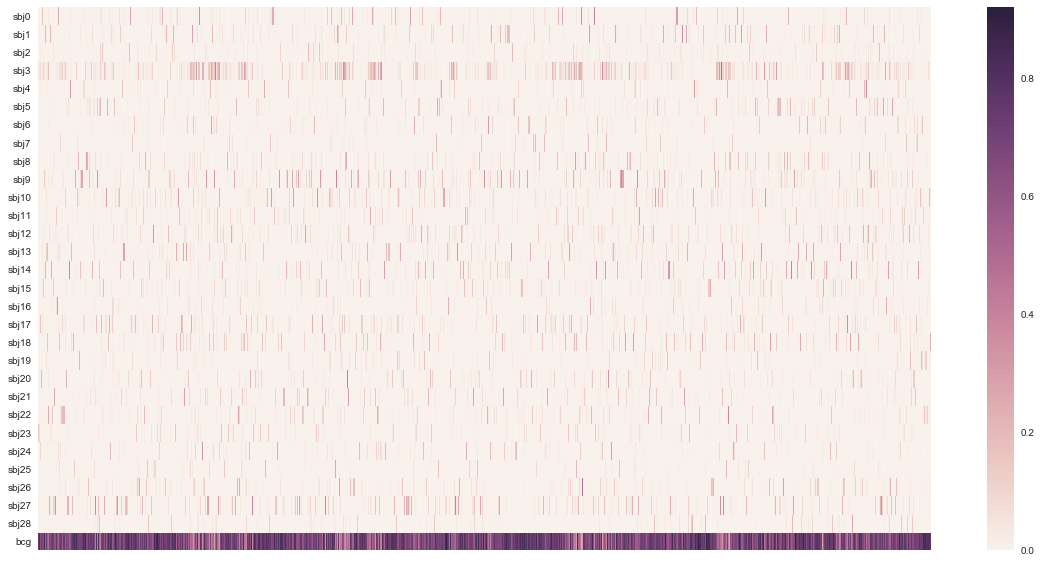

In [177]:
# Ваш код
fig, axes = plt.subplots(1, 1, figsize=(20, 10), sharey=True)
seaborn.heatmap(theta[0:100], xticklabels=False)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [178]:
# Ваш код

S = theta.sum( axis=1 )
T = pd.DataFrame( data=S/S.sum(), columns=['p(t)'])
T.index = topic_labels
T.sort_values('p(t)')

,p(t)
Смерть,0.003850
Программирование,0.003986
Сверхпроводимость,0.005238
География,0.005796
Революция,0.005871
Учёба,0.005906
Схема,0.005917
Литература,0.007173
Семья,0.007344
Право,0.007676


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

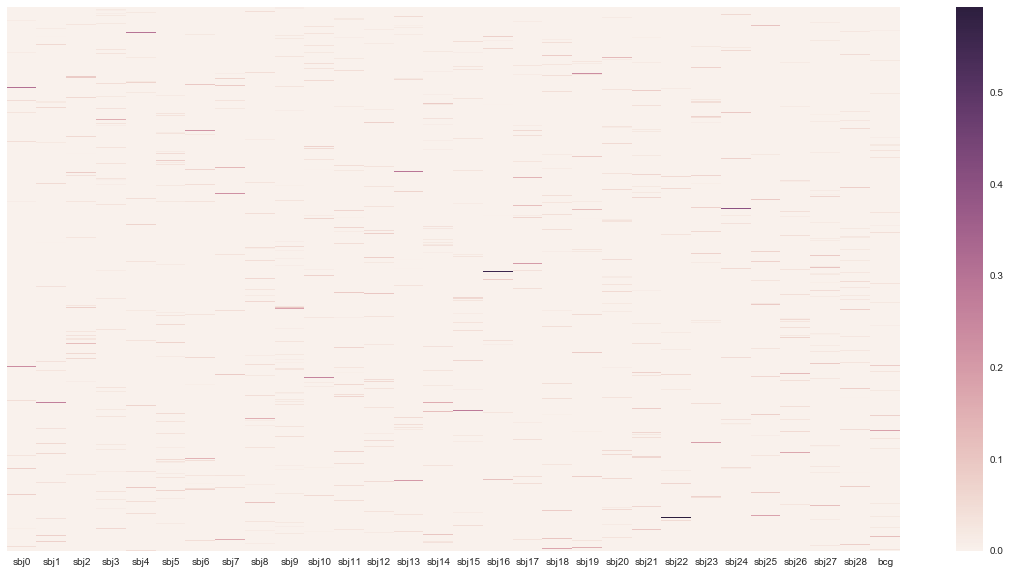

In [179]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a,yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [181]:
#Ваш ответ:
#авторы, значимые в не менее чем 3 темах:
for ind, row in phi_a.iterrows():
    cnt = row[row > 0.01].count()
    print ind, cnt
print '\n' + 'Самые значимые:'
for ind, row in phi_a.iterrows():
    cnt = row[row > 0.01].count()
    if cnt >= 3:
        print ind, cnt

Дэвид_Гросс 1
Павел_Степанцов 1
Ирина_Каспэ 1
Александр_Беленький 1
Татьяна_Гусарова 1
Андрей_Коротаев 1
Галина_Зеленина 1
Ирина_Левонтина 1
Алексей_Малашенко 1
Дэвид_Кларк 1
Михаил_Полуэктов 1
Алексей_Москалев 1
Екатерина_Болтунова 1
Юрий_Рогулёв 1
Антон_Чугунов 1
Александр_Мещеряков 1
Алексей_Котов 1
Георгий_Старостин 1
Илья_Виньковецкий 1
Кирилл_Кожанов 1
Сергей_Таскаев 1
Сергей_Нечаев 1
Кристофер_Карр 1
Валерий_Рязанов 1
Дмитрий_Дождев 1
Илья_Кукулин 1
Анна_Рогожина 2
Марина_Корсакова-Крейн 1
Андрей_Иванцов 1
Дэвид_С._Джонс 1
Андрей_Семенов 1
Ирина_Секерина 1
Георгий_Базыкин 2
Игорь_Уточкин 1
Петр_Аркадьев 1
Роберт_Лэнгер 1
Татьяна_Смоктунович 1
Людмила_Новикова 1
Сергей_Гашков 1
Алексей_Гиппиус 1
Сергей_Писарев 1
Максим_Кронгауз 1
Иван_Ладынин 1
Сергей_Блинников 1
Ольга_Тогоева 3
Андрей_Лукашов 1
Алексей_Кавокин 1
Александр_Пиперски 1
Игорь_Волобуев 1
ПостНаука 2
Дэвид_Синклер 1
Евгений_Хоров 1
Александр_Кислов 1
Марина_Новикова-Грунд 1
Григорий_Юдин 2
Борис_Колоницкий 2
Екатерина

Дмитрий_Арзютов 1
Игорь_Исаев 1
Денис_Сивков 1
Виктор_Вахштайн 1
Наталья_Новикова 1
Константин_Лукьянов 1
Светлана_Баньковская 1
Пётр_Образцов 1
Эдуард_Боос 1
Дмитрий_Казанцев 1
Александр_Шень 1
Александр_Каплан 1
Дмитрий_Гитман 1
Андрей_Головин 1
Павел_Уваров 1
Петр_Федичев 2
Алексей_Витухновский 1
Сергей_Серёгичев 1
Архат_Абжанов 1
Виктор_Задков 1
Алексей_Расторгуев 1
Александр_Марков 1
Сергей_Неклюдов 1
Евгений_Магид 1
Андрей_Кибрик 1
Михаил_Маяцкий 2
Мария_Неклюдова 2
Дмитрий_Вибе 2
Михаил_Ревнивцев 1
Виктор_Авдеев 1
Илья_Шкредов 1
Светлана_Боринская 1
Елена_Уханова 1
Алексей_Миллер 1
Владимир_Плунгян 1
Николай_Дронин 1
Виктор_Цетлин 1

Самые значимые:
Ольга_Тогоева 3
Ольга_Вайнштейн 5
Александр_Воеводский 3
Илья_Иткин 3
Алина_Бодрова 3


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [112]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [182]:
# Ваш код
p_ta = phi_a.get_values() * T.get_values().reshape((1,30)) / phi_a.get_values().dot(T.get_values())
mds = MDS(n_components = 2, n_init = 1, max_iter = 100, dissimilarity='precomputed')
p_ta_mds = mds.fit_transform(pairwise_distances(p_ta, metric='cosine'))

Визуализируйте найденные двумерные представления с помощью функции scatter. 

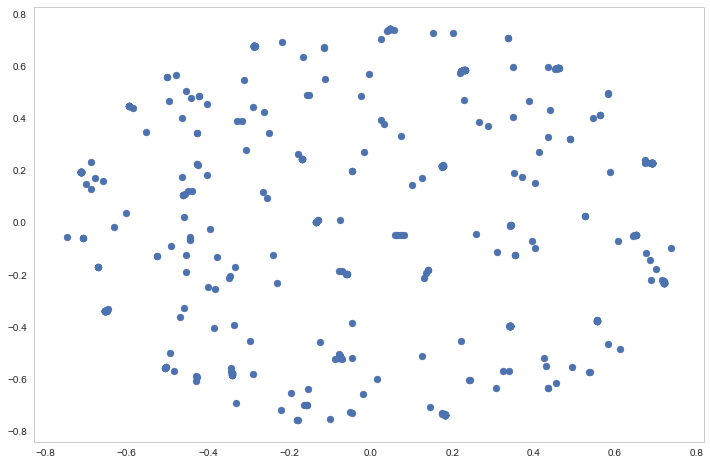

In [183]:
# Ваш код
plt.figure(figsize=(12, 8))
plt.scatter(p_ta_mds[:, 0], p_ta_mds[:, 1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

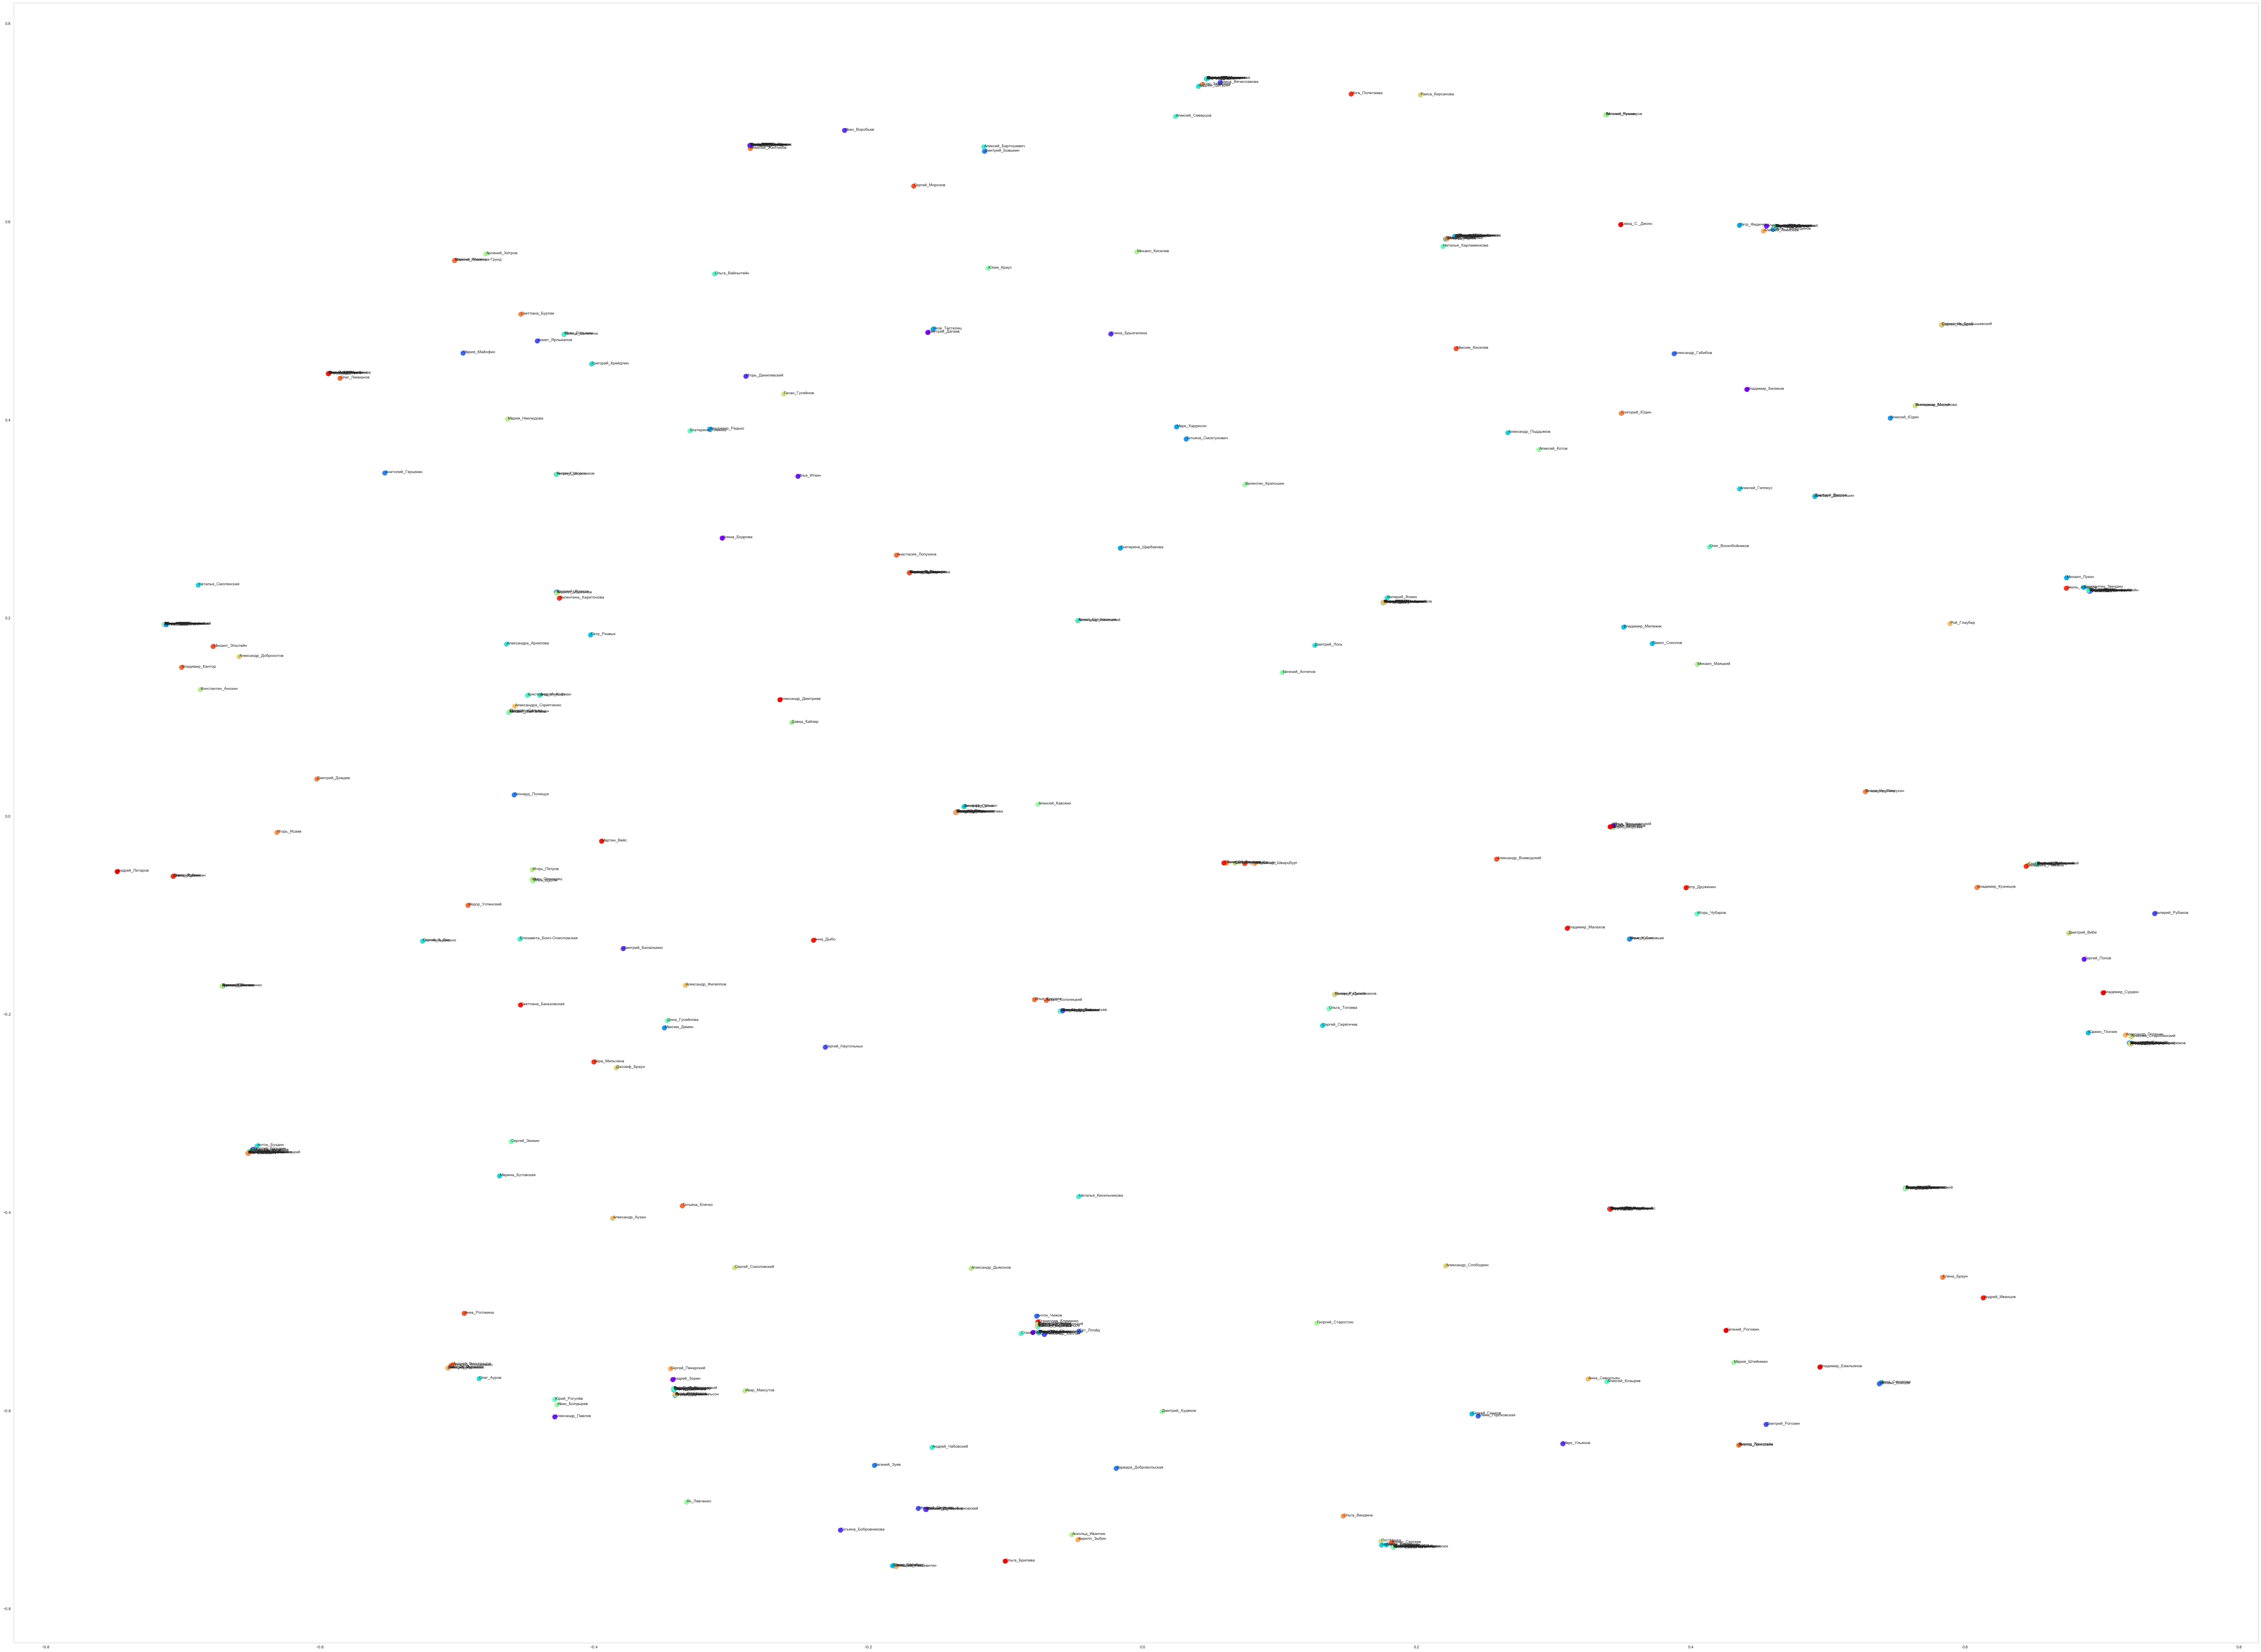

In [187]:
import matplotlib.cm as cm
T = 30
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
plt.figure(figsize=(100, 75))
plt.scatter(p_ta_mds[:, 0], p_ta_mds[:, 1], s=150, c=colors, cmap=p_ta.argmax(axis=1))
for idx, xy in enumerate( p_ta_mds ):
    plt.annotate(phi_a.index[idx], xy=xy)
plt.savefig('postnauka.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [189]:
# Ваш код
values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [117]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [118]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [195]:
# Ваш код
tokens = model_artm.score_tracker["top_words_text"].last_tokens
for idx, topic_name in enumerate(topic_labels):
    display(HTML(u"<h2>"+topic_name.decode('UTF-8')+"</h2>"))
    display(HTML(u'<h4>'+' '.join(tokens[topic_names[idx]][:10] )+'</h4>'))
    url_arr = []
    for n in range(10): 
        display(HTML(u"<ul>"+'<li>'+u'<a href="'+theta.columns[i_p_dt[idx][n]]+'">'+
                     theta.columns[i_p_dt[idx][n]]+'</a>'+'</li>'+"</ul>"))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 